# Churn Prediction for Gym's Customers

## Introduction

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.

One of the most common problems gyms and other services face is customer churn. How do you know if a customer is no longer with you? You can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, you can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: your follower might have gotten bored and left you.

For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. Our task is to analyze them and come up with a customer retention strategy.

**Description of the data:**

Model Fitness provided us with CSV files containing data on churn for a given month and information on the month preceding it.
The dataset includes the following fields:

- `'Churn'` — the fact of churn for the month in question
Current dataset fields:
User data for the preceding month


- `'gender'`


- `'Near_Location'` — whether the user lives or works in the neighborhood where the gym is located


- `'Partner'` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)


- `Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)


- `'Phone'` — whether the user provided their phone number


- `'Age'`


- `'Lifetime'` — the time (in months) since the customer first came to the gym

Data from the log of visits and purchases and data on current membership status


- `'Contract_period'` — 1 month, 3 months, 6 months, or 1 year


- `'Month_to_end_contract'` — the months remaining until the contract expires


- `'Group_visits'` — whether the user takes part in group sessions


- `'Avg_class_frequency_total'` — average frequency of visits per week over the customer's lifetime


- `'Avg_class_frequency_current_month'` — average frequency of visits per week over the preceding month


- `'Avg_additional_charges_total'` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

<h2>Tables Of Contents <a class="anchor" id="table_of_contents"></a></h2>

- [1. Download the data & import libraries](#open)
- [2. Carry out exploratory data analysis (EDA)](#eda)
- [3. Build a model to predict user churn](#model)
- [4. Create user clusters](#cluster)
- [5. Conclusion and recommendations](#conclusion)

## Download the data & import libraries

<a class="anchor" id="open"></a>
[Go back to the Table of Contents](#table_of_contents)

In [59]:
# !pip install -U seaborn
# !pip install sidetable -U

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sidetable
import sys
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [7]:
try:
    clients = pd.read_csv('gym_churn_us.csv')
except:
    clients = pd.read_csv('/datasets/gym_churn_us.csv')

In [8]:
# ignore 'FutureWarnings'
if not sys.warnoptions:
       warnings.simplefilter("ignore")

## Exploratory data analysis (EDA)

<a class="anchor" id="eda"></a>
[Go back to the Table of Contents](#table_of_contents)

**1. Let's look at the dataset: does it contain any missing features? We'll study the mean values and standard deviation of the dataset's features.**

First, let's take a look at the general information of the data, using the methods: `head()`, `info()`. 

In [9]:
# print the first 10 rows of clients
clients.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Some columns' names contain uppercase letters, which is a bad practice. We'll change this by using the `str.lower()` method:  

In [10]:
clients.columns = clients.columns.str.lower()

In [11]:
# use the info() method to check columns' data type
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [12]:
# use stb.missing() method to detect missing values in the dataset
clients.stb.missing(style=True)

,missing,total,percent
gender,0,"4,000",0.00%
near_location,0,"4,000",0.00%
partner,0,"4,000",0.00%
promo_friends,0,"4,000",0.00%
phone,0,"4,000",0.00%
contract_period,0,"4,000",0.00%
group_visits,0,"4,000",0.00%
age,0,"4,000",0.00%
avg_additional_charges_total,0,"4,000",0.00%
month_to_end_contract,0,"4,000",0.00%


There are no missing values, and each column has the correct data type.

Now, let's check if we have duplicates in our data:

In [13]:
print('The number of duplicates in the dataset is: {}'.format(clients.duplicated().sum())
      if (clients.duplicated().sum()) > 0
      else 'There are no duplicates in the dataset')

There are no duplicates in the dataset


Great! we can move on to the next task.

Next, we'll use the `describe()` method to get basic statistical information about the data.

Only non-binary columns will be considered, meaning their values are not True/False indicators (Statistical metrics don't provide useful insights for binary columns).

In [14]:
# create a list of non-binary columns in clients
non_binary = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
             'avg_class_frequency_total', 'avg_class_frequency_current_month']

clients[non_binary].describe().T

,count,mean,std,min,25%,50%,75%,max
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


**Main insights:**


- Info about `contract_period` suggests that 75% of customers sign contracts for fewer than 6 months, at least half of the gym's customers are signed for a 1-month subscription. The average subscription period is 4.68 with std value of 4.54.


- The age of customers is normally distributed (mean almost equal to median), the mean value is 29.18.


- `avg_additional_charges_total`, `lifetime` columns could contain some outliers (mean is higher than the median), standard deviation values for both columns are high.


- Info about `month_to_end_contract` suggests that at least half of the gym's customers are one month away from the end of their subscription.


- The average number of customer visits per week is somewhat less than 2, with a standard deviation of about 1. 

**2. Let's look at the mean feature values in two groups: for those who left (`churn` = 1) and for those who stayed.**

Using the `groupby` method, we'll calculate the mean feature values to each of the following groups:
1. Active members of the gym (`churn` = 0).


2. Former members of the gym (`churn` = 1).

Here, binary columns do provide useful insights, so we'll display all the features in the dataframe:

In [15]:
clients.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Key takeaways:**


- More active members are in close proximity to the gym than former members.


- More active members are signed through 'Partner companies' to the gym than former members.


- More active members are signed through 'Promo friend' to the gym than former members.


- In comparison to former members, more active members attend group sessions.


- On average, active members are 3 years older than former members.


- The average active member spends more on gym services than a former member.


- Active/former members have an average remaining contract term of 5.28 months and 1.66 months, respectively.


- Active/former members have an average lifetime of 4.71 months and 0.99 months, respectively.


- On average, active members visit the gym more often than former members.

**3. Let's plot bar histograms and feature distributions for those who left (churn) and those who stayed.**

The histograms will be plotted only for the non-binary columns in the dataframe, since binary columns don't provide us with useful information about outliers or customer distribution (beyond what we concluded in previous steps).

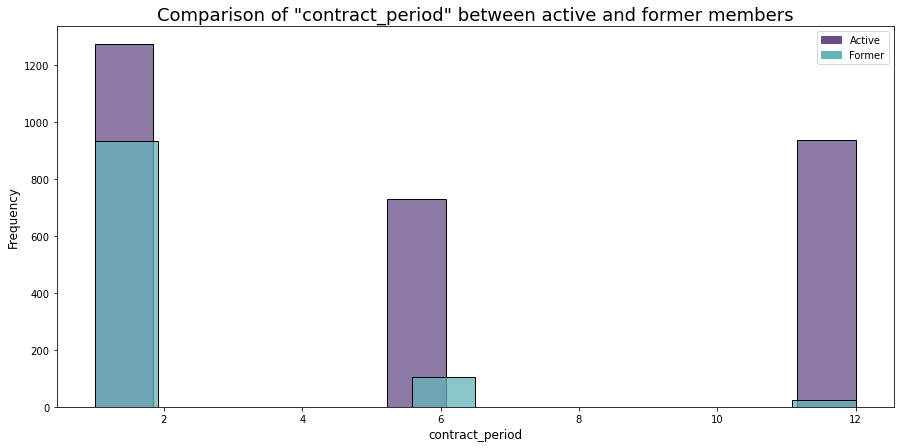

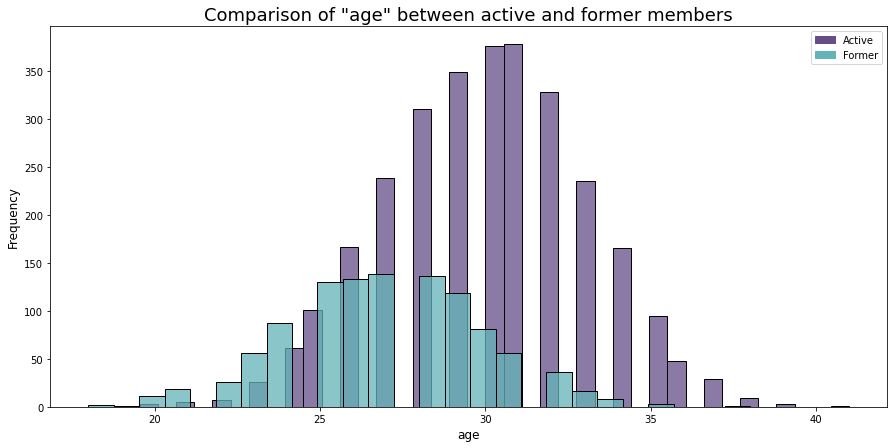

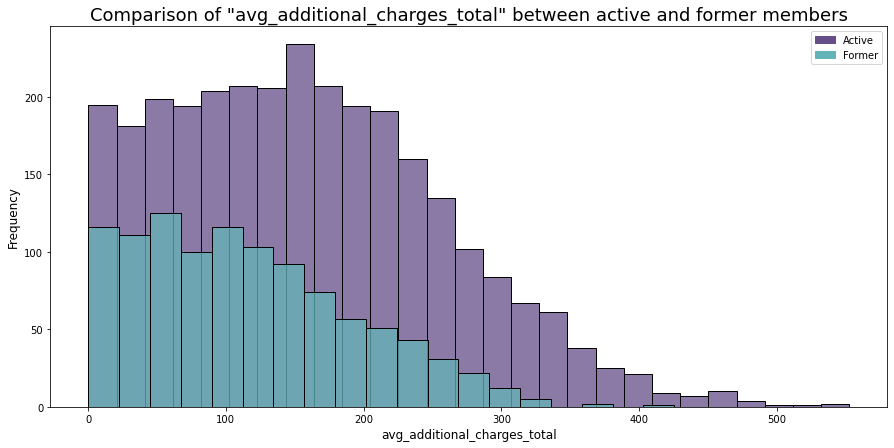

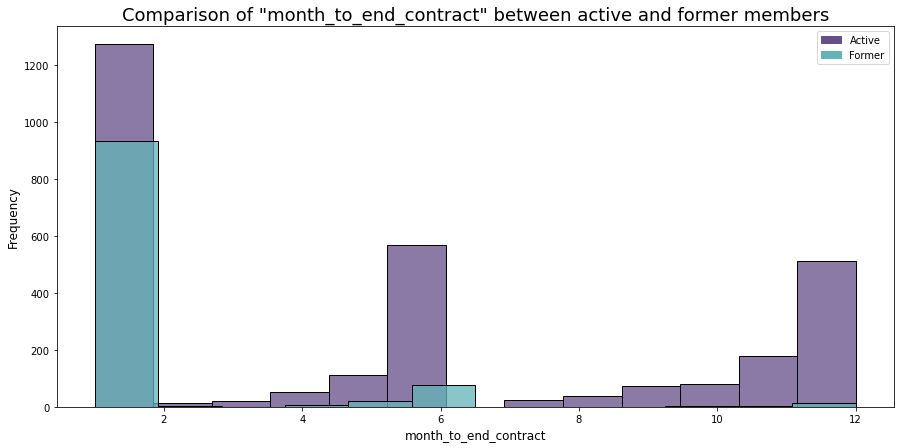

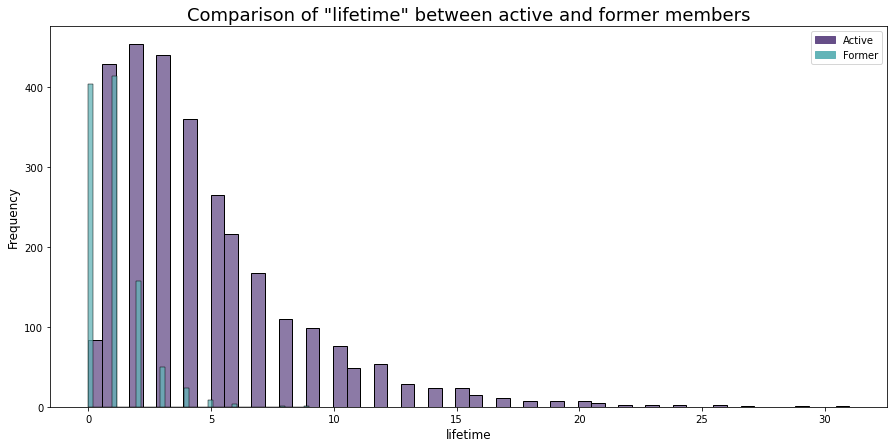

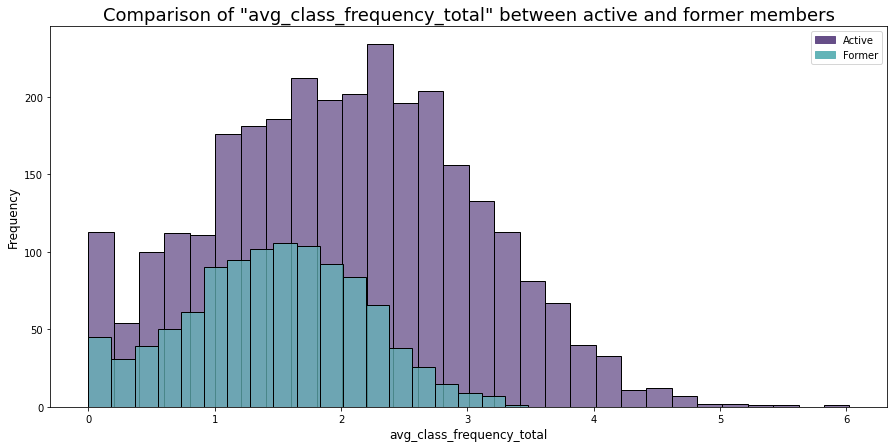

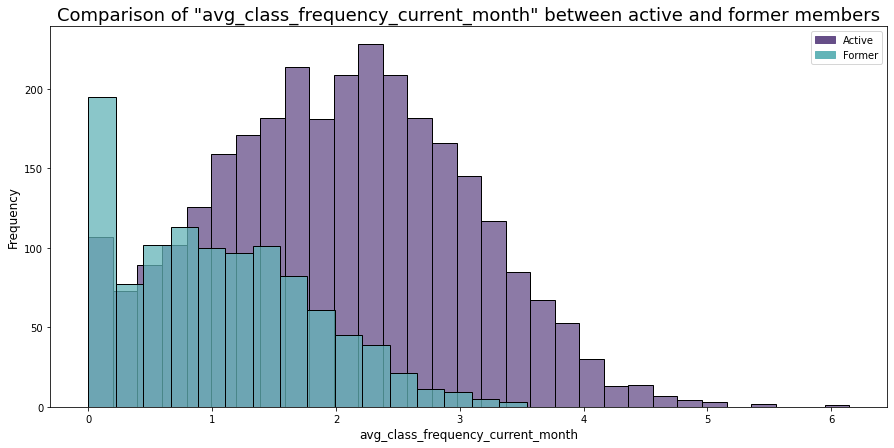

In [16]:
# loop through the non-binary features, and plot histograms
for feature in non_binary:
    fig, axs = plt.subplots(figsize=(15,7))

    # plot two histograms, one for active members, one for former members
    sns.histplot(clients.query('churn == 0')[feature], color='#664E88')
    sns.histplot(clients.query('churn == 1')[feature], color='#63B4B8')
    
    # add title and x/y labels
    plt.title('Comparison of "' + feature + '" between active and former members', size=18)
    plt.xlabel(feature, size=12)
    plt.ylabel('Frequency', size=12)

    # add legend
    active_hist = mpatches.Patch(color='#664E88', label='Active')
    former_hist = mpatches.Patch(color='#63B4B8', label='Former')
    plt.legend(handles=[active_hist, former_hist])


plt.show()   

Overall, there are significant differences in each feature between the groups (active/former members).

Looking at the features' distributions, a few insights come up:
- In general, former members tend to be younger than active members, with the majority of them (former members) are 20-30 years old.


- Former members spend less on additional services than active members.


- The majority of former members signed a 1-month contract.


- Former members have fewer visits per week to the gym.

Moreover, in each of the following features: 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', and 'avg_class_frequency_current_month' we can notice outliers.

Let's write a function that will determine lower and upper limits for each of these features, later we'll filter the data with these limits.

This step will allow us to get more precise results from our model since the dataset will be less skewed.

In [17]:
# we'll use the formulas (Q1 - 1.5 * IQR), and (Q3 + 1.5 * IQR) to set the limits for each feature's values 
def determine_outliers(feature_column):
    Q1,Q3 = np.percentile(feature_column, [25,75])
    IQR = Q3 - Q1
    lower_lim = Q1 - (1.5 * IQR)
    upper_lim = Q3 + (1.5 * IQR)
    
    return lower_lim, upper_lim

In [18]:
# list of features we suspected to contain outliers
feature_with_outliers = ['age', 'avg_additional_charges_total', 'lifetime',
                         'avg_class_frequency_total', 'avg_class_frequency_current_month']
# create a new clients
clients_filtered = clients

# loop through each 'suspected' feature and set limits with the function 'determine_outliers'
# then filter the dataframe with each tuple of limits for each feature

for feature in feature_with_outliers:
    limits = determine_outliers(clients_filtered[feature])
    clients_filtered = clients_filtered.loc[(clients_filtered[feature] >= limits[0]) & (clients_filtered[feature] <= limits[1])]

Let's calculate how much data we lost after the filtering:

In [19]:
print('Percentage of data lost after removing outliers: {:.2%}'.format(1 - (len(clients_filtered)/len(clients))))

Percentage of data lost after removing outliers: 6.73%


Our dataset was lost by 6.73%, but that is not a significant amount, and now we can get a more accurate model.

**4. Let's build a correlation matrix and visualize it.**

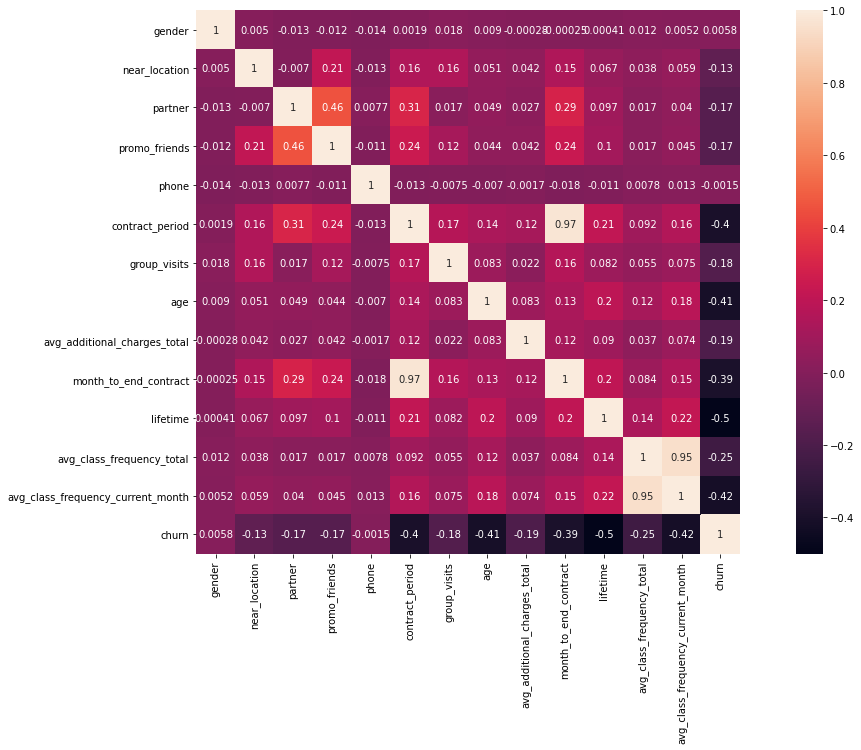

In [20]:
cm = clients_filtered.corr() # calculate correlation matrix
fig, ax = plt.subplots(figsize=(20,10))

# plot an annotated heatmap for the correlation matrix
sns.heatmap(cm, annot = True, square=True)
plt.show()

**Main insights:**
- There are two pairs features with strong mutual correlation:
    
    1. `contract_period` and `month_to_end_contract`.
    
    2. `avg_class_frequency_total` and `avg_class_frequency_current_month`
  
  It makes sense because these pairs are interdependent on each other.
  

- `contract_period`, `age`, `lifetime`, and `average_class_frequency_current_month` have a somewhat negative correlation with `churn`, but we wouldn't say this is a strong correlation.

## Conclusion

To conclude, initially, we took a look at the general information of the dataset. We didn't find any missing values or duplicates in the data.

Then we looked at the basic statistical information of the dataset.

We were able to draw the following insights:

- Info about `contract_period` suggests that 75% of customers sign contracts for fewer than 6 months, at least half of the gym's customers are signed for a 1-month subscription. The average subscription period is 4.68 with a standard deviation value of 4.54.


- The age of customers is normally distributed (mean almost equal to median), the mean value is 29.18.


- `avg_additional_charges_total`, `lifetime` columns could contain some outliers (mean is higher than the median), standard deviation values for both columns are high.


- Info about `month_to_end_contract` suggests that at least half of the gym's customers are one month away from the end of their subscription.


- The average number of customer visits per week is somewhat less than 2, with a standard deviation of about 1. 

Later, we split the data into two groups, one for customers who left, and one for customers who stayed.

Then, we calculated the mean of each feature in the groups.

Here are the key takeaways from this step:

- More active members are close to the gym than former members.


- More active members are signed through 'Partner companies' to the gym than former members.


- More active members are signed through 'Promo friend' to the gym than former members.


- In comparison to former members, more active members attend group sessions.


- On average, active members are 3 years older than former members.


- The average active member spends more on gym services than a former member.


- Active/former members have an average remaining contract term of 5.28 months and 1.66 months, respectively.


- Active/former members have an average lifetime of 4.71 months and 0.99 months, respectively.


- On average, active members visit the gym more often than former members.

Next, we plotted histograms for the features in each group, compared the different distributions, and noticed outliers in some of the features.

We wrote a function to filter out these outliers and continued our analysis with the filtered data (only 6.73% of data was lost).

Lastly, we built a correlation matrix and plotted a heatmap to display it.

After analyzing the matrix we arrived at the following conclusions:

- There are two pairs of features with strong mutual correlation:
    
    1. `contract_period` and `month_to_end_contract`.
    
    2. `avg_class_frequency_total` and `avg_class_frequency_current_month`
  
  It makes sense because these pairs are interdependent.
  

- `contract_period`, `age`, `lifetime`, and `average_class_frequency_current_month` have a somewhat negative correlation with `churn`, but we wouldn't say this is a strong correlation.

# Build a model to predict user churn

<a class="anchor" id="model"></a>
[Go back to the Table of Contents](#table_of_contents)

At this step, we'll build a binary classification model for customers where the target feature is the user's leaving next month.

**Let's divide the data into train and validation sets using the `train_test_split()` function:**

In [21]:
# divide the DataFrame into a target variable and training features

X = clients_filtered.drop(['churn'], axis = 1)
y = clients_filtered['churn']

# Divide the set into train and validation data
# test_size - the share of the dataset to be split off for validation
# random_state - the parameter for reproducing the result

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Next, we'll train the model on the train set with two methods:**
 1. Logistic regression
 2. Random forest

**Logistic regression:**

In [37]:
# define the model's algorithm 
lr_model = LogisticRegression()

# train your model
lr_model.fit(X_train, y_train)

# binary prediction
lr_pred = lr_model.predict(X_test)

**Random forest:**

In [38]:
# defining the new model's algorithm based on the random forest algorithm
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# train your model
rf_model.fit(X_train, y_train)

# binary prediction
rf_pred = rf_model.predict(X_test) 

**Let's evaluate accuracy, precision, and recall for both models using the validation data. We'll use them to compare the models.**

First, we'll write a function that will output our metrics:

In [39]:
def print_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [40]:
# print metrics for logistic regression
print(print_metrics(y_test, lr_pred, title='Metrics for logistic regression:'))

# print metrics for random forest
print(print_metrics(y_test, rf_pred, title='Metrics for random forest:'))

Metrics for logistic regression:
	Accuracy: 0.92
	Precision: 0.90
	Recall: 0.79
None
Metrics for random forest:
	Accuracy: 0.91
	Precision: 0.89
	Recall: 0.79
None


The two models perform very similarly, the logistic regression model wins out over the random forest model by a narrow margin.

Let's see which features affect the prediction of the logistic regression model the most, we'll plot bar chart with the values of feature's importance sorted in decending order:

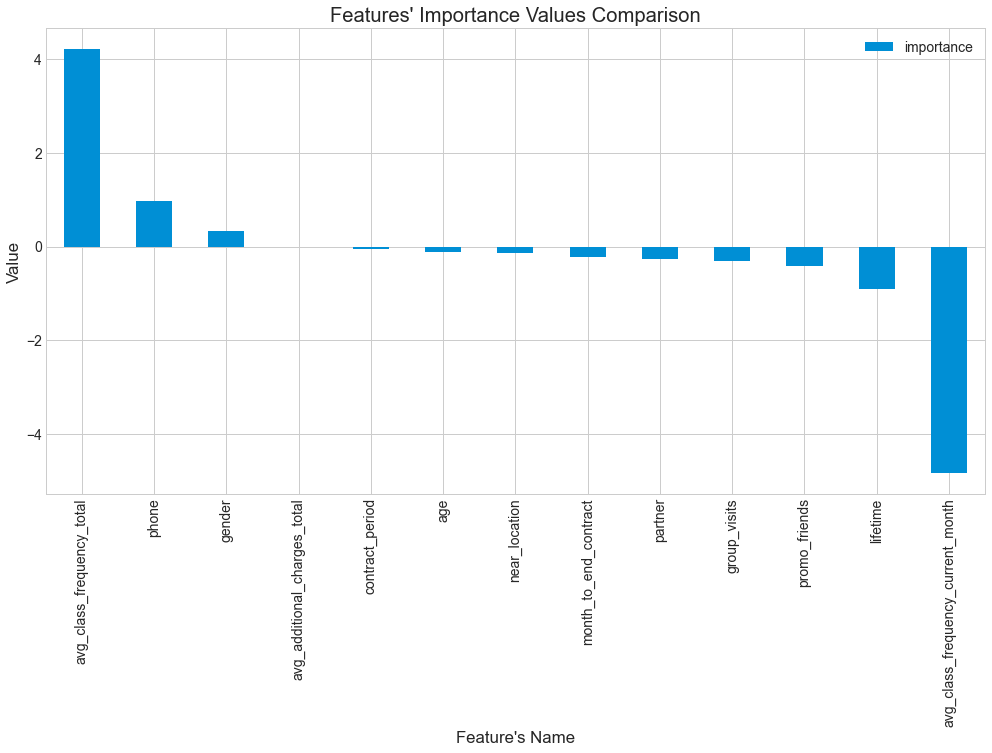

In [76]:
#set theme style
plt.style.use('seaborn-whitegrid') 

# create a DataFrame with feature names and importance
feature_importance_lr = pd.DataFrame(data ={'feature': X.columns, 'importance': lr_model.coef_[0] })

# plot bar chart
feature_importance_lr.sort_values('importance', ascending = False).plot(kind='bar', x='feature', figsize=(15,8))
# set title and x/y labels
plt.gca().set(title="Features' Importance Values Comparison", xlabel="Feature's Name", ylabel='Value')
plt.show()

Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

From the graph above we can that `avg_class_frequency_total` has the highest positive value, on the other hand, `avg_class_frequency_current_month` has the "highest" negative score. Features like `lifetime`, `promo_friends`, `group_visits`, `phone` have impact as well on whether the model predict 0 or 1. 

## Conclusion

In conclusion, at this step, we built a binary classification model for customers where the target feature is the user's leaving next month.

We divided the data into train and validation data with a ratio of 80%/20%.

We trained the model on the train set with two methods:
- Logistic regression
- Random forest

Later we evaluated the two models using the following metrics: accuracy, precision, and recall.

The logistic regression model performed better than the random forest model by a small margin.

Here are the evaluated metrics of the logistic regression model:

- Accuracy: 0.92
- Precision: 0.90
- Recall: 0.79

# Create user clusters

<a class="anchor" id="cluster"></a>
[Go back to the Table of Contents](#table_of_contents)

We will use clustering to create customers segments at this step.

**1. Standardize the data first, since it is essential for clustering.**

In [21]:
# standardize the data
sc = StandardScaler()
# train and transform
# X is the feature matrix we created in previous step
X_sc = sc.fit_transform(X)

**2. Next, we'll use the `linkage()` function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram.**

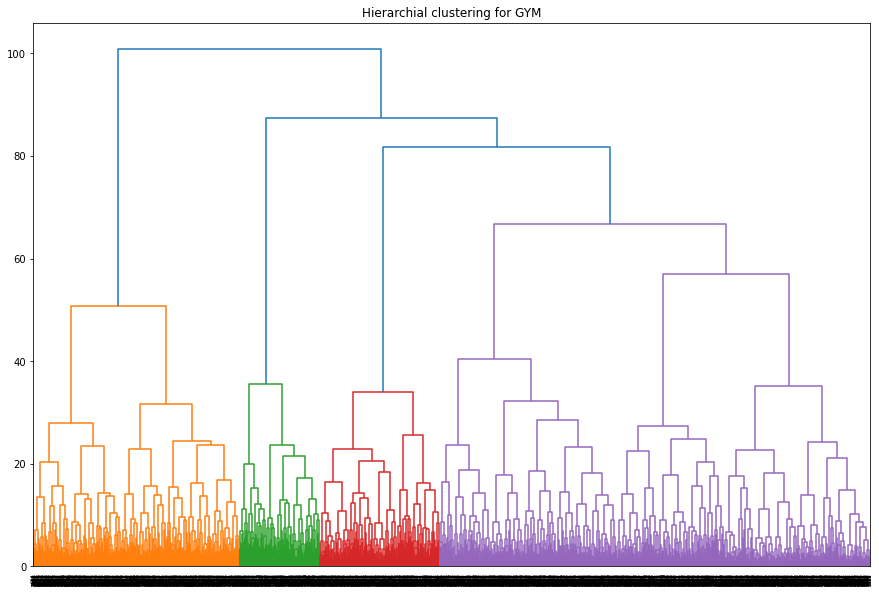

In [22]:
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

As we can see from the dendrogram above, there are four different colors, but the purple group looks bigger in comparison with the others, and it appears that it can be split up further.
We'll set the threshold at five clusters.

**3. Let's train the clustering model with the K-means algorithm and predict customer clusters.**

In [23]:
km = KMeans(n_clusters = 5) # setting the number of clusters as 5
labels = km.fit_predict(X_sc) # applying the algorithm to the data and forming a cluster vector

Next, we'll asign the `labels` values to a new column in `clients_filtered`:

In [24]:
# store cluster labels in the field of our dataset
clients_filtered['cluster'] = labels

**4. Let's look at the mean feature values for clusters:**

In [25]:
# get the statistics of the mean feature values per cluster
feature_mean = clients_filtered.groupby('cluster').agg('mean')

# print the table
feature_mean

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.501139,0.945330,0.744875,0.486333,0.894077,11.774487,0.541002,29.915718,162.218029,10.779043,4.075171,1.961661,1.952090,0.023918
1,0.486207,1.000000,0.827586,1.000000,0.903448,3.079310,0.439655,29.029310,137.718755,2.900000,2.960345,1.650424,1.527457,0.281034
2,0.496109,0.000000,0.476654,0.077821,0.914397,2.178988,0.208171,28.542802,131.298064,2.044747,2.445525,1.645514,1.446101,0.466926
3,0.493732,1.000000,0.235294,0.015429,0.907425,1.960463,0.315333,28.222758,128.236101,1.876567,2.050145,1.278578,1.027770,0.551591
4,0.569252,0.966759,0.267313,0.123269,0.904432,2.804709,0.494460,30.149584,156.807562,2.574792,4.222992,2.871207,2.871037,0.067867


**Key insights:**
1. Clusters 0 and 4:
    - Cluster 0 is leading the clusters in terms of the average contract period (11.76), which suggests that most customers in this segment signed a 12-month contract.
    - Moreover, most customers in both clusters are living close to the gym, about half of the customers in each cluster attend group visits.
    - On average, they are the biggest spenders on additional services, they visit the gym more than other clusters and their average lifetime is higher.
    - They have the smallest averages of churn in comparison to other clusters.


2. Cluster 1:
    - All customers in this segment are living close to the gym, signed through a friend.
    - Most of them get partner discounts, and the average churn is 0.27, meaning that about a quarter of customers in this segment are former members.
    
    

3. Clusters 2 and 3:
    - All customers in cluster 3 are living close to the gym, all the others in cluster 2 don't live close to the gym.
    - Most of them didn't sign through a friend/partner company (in both clusters).
    - On average, they attend fewer group visits and attend fewer classes in general.
    - In both clusters, the customers' contract period is the shortest on average, they are slightly younger than the rest, and they spend less money on additional services.
    - These clusters' average churn is the highest of the bunch (about half the customers in each cluster left the gym).

**5. Let's plot distributions of features for the clusters.**

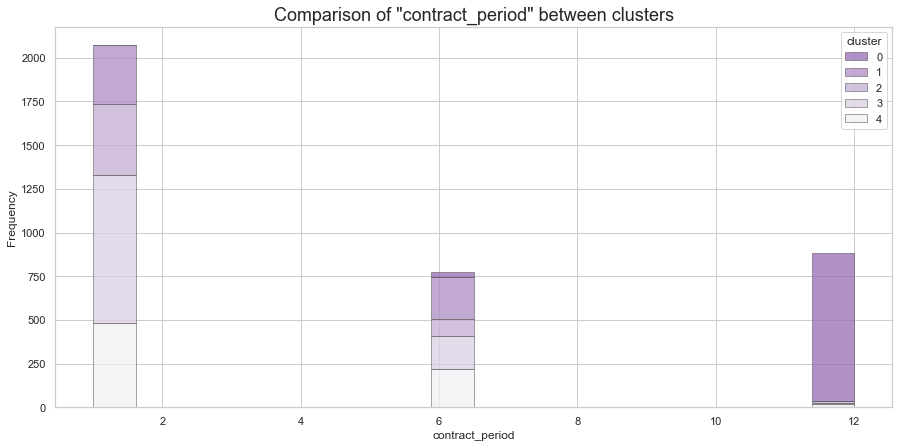

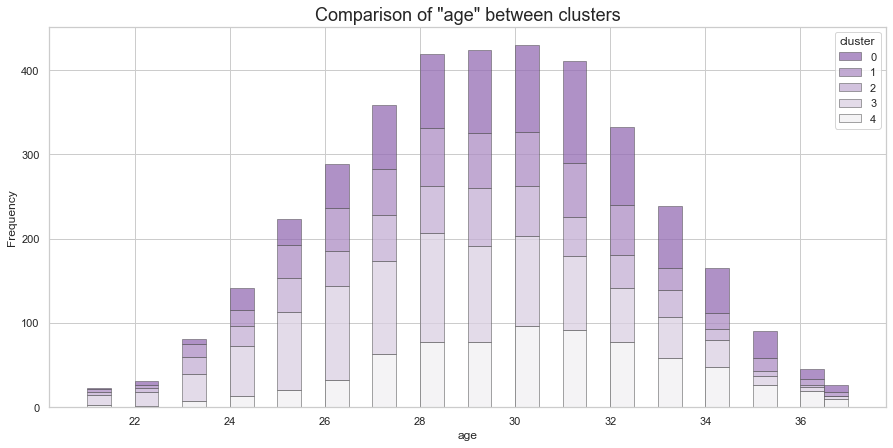

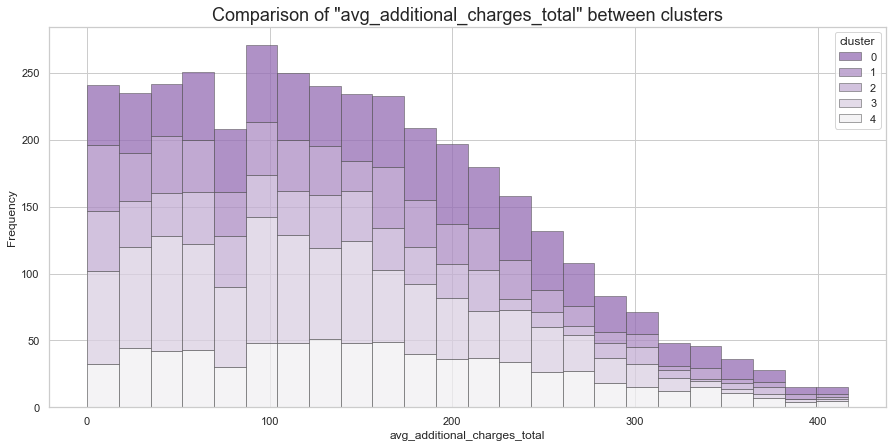

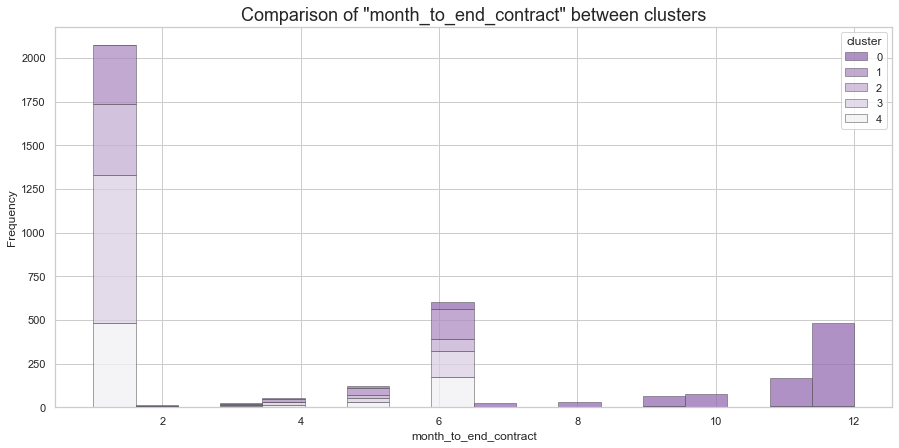

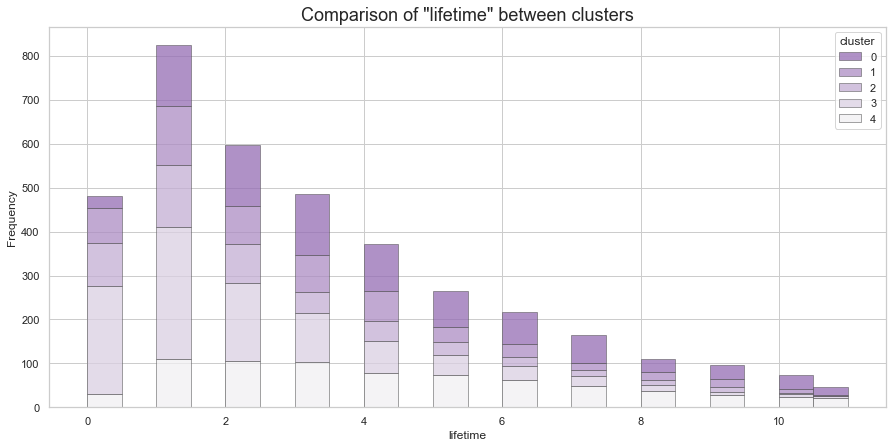

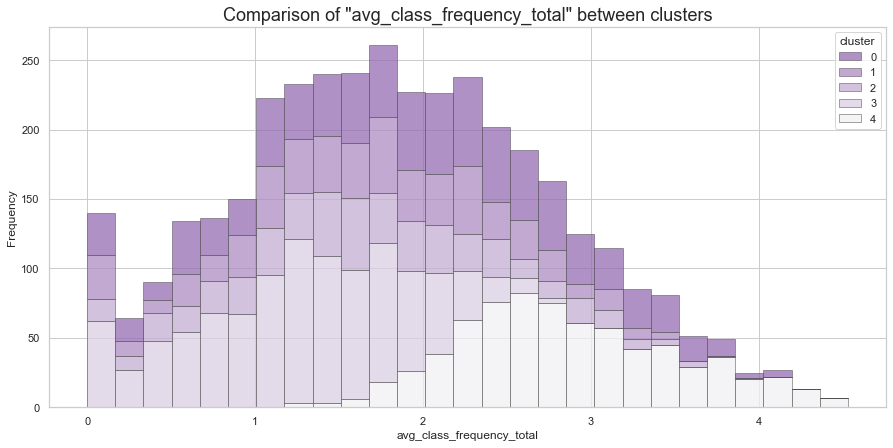

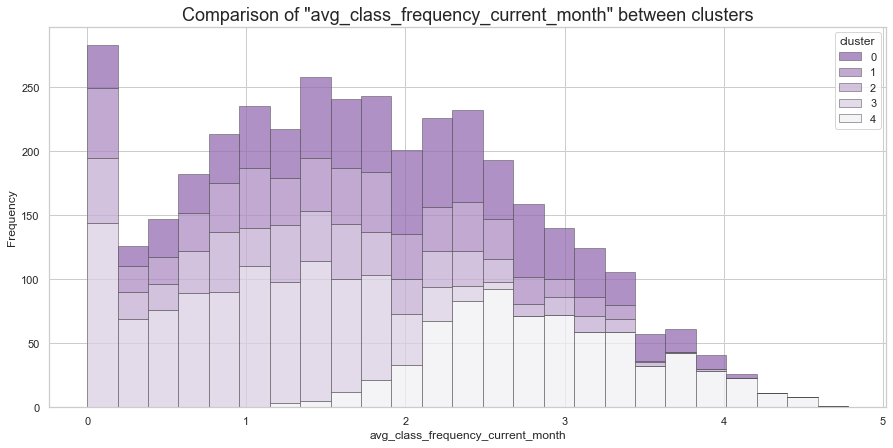

In [26]:
# set theme
sns.set_theme(style="whitegrid", palette="muted")

# loop through the non-binary features, and plot histograms
for feature in non_binary:
    # set figure
    fig, axs = plt.subplots(figsize=(15,7))

    sns.histplot(
        clients_filtered,
        x=feature, hue="cluster",
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,    
    )
    
    # add title and x/y labels
    plt.title('Comparison of "' + feature + '" between clusters', size=18)
    plt.xlabel(feature, size=12)
    plt.ylabel('Frequency', size=12)

plt.show() 

**Main insights:**

- Most customers who signed a 12-month contract were from cluster 0.


- Younger customers tend to be in clusters 2 and 3.


- The average spending on additional services is higher for customers in clusters 0 and 4.


- Clusters 0 and 4 have a larger share of customers with lifetime values higher than 4.


- Clusters 0 and 4 customers (especially 4) visit the gym more frequently.

**Let's calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?**

Let's write a single-row function to calculate churn rate for each cluster individually:

In [54]:
def calc_churn_rate(row):
    # assign values: cluster's number and count of former members
    cluster_num = row['cluster_num']
    churn_cnt = row['former_customers_cnt']
    
    # calculate the churn rate
    churn_rate = float("{:.2f}".format((churn_cnt / len(clients_filtered.query('cluster == @cluster_num'))) * 100))
    
    return churn_rate

In [57]:
# group by cluster and sum the values in churn column
churn_rate_by_cluster = clients_filtered.groupby(['cluster'], as_index=False)['churn'].sum()

# rename columns
churn_rate_by_cluster.columns = ['cluster_num', 'former_customers_cnt']

# apply function
churn_rate_by_cluster['churn_rate'] = churn_rate_by_cluster.apply(calc_churn_rate, axis=1)

# print table sorted by churn rate in %
churn_rate_by_cluster.sort_values('churn_rate', ascending = False)

,cluster_num,former_customers_cnt,churn_rate
3,3,572,55.16
2,2,240,46.69
1,1,163,28.10
4,4,49,6.79
0,0,21,2.39


From the table above we can conclude:
- With churn rates of 55.15 % and 46.69%, clusters 3 and 2 are especially prone to losing customers.


- Customers in cluster 4 and 0 are the most loyal, with churn rates as low as 6.79% and 2.39%, respectively.


- Cluster 1's churn rate is 28.1%.

## Conclusion

To conclude, at this step, we used clustering to create user segments.

First, we standardized the data and plotted a dendrogram to help us decide how many clusters we'll assign to the K-Means algorithm later.

We set the number of clusters to five and begun to train the K-means algorithm and predict customer clusters.

Next, we looked at the mean feature values for clusters and arrived at the following insights:

1. Clusters 0 and 4:
    - Cluster 0 is leading the clusters in terms of the average contract period (11.76), which suggests that most customers in this segment signed a 12-month contract.
    - Moreover, most customers in both clusters are living close to the gym, about half of the customers in each cluster attend group visits.
    - On average, they are the biggest spenders on additional services, they visit the gym more than other clusters and their average lifetime is higher.
    - They have the smallest averages of churn in comparison to other clusters.


2. Cluster 1:
    - All customers in this segment are living close to the gym, signed through a friend.
    - Most of them get partner discounts, and the average churn is 0.27, meaning that about a quarter of customers in this segment are former members.
    
    

3. Clusters 2 and 3:
    - All customers in cluster 3 are living close to the gym, all the others in cluster 2 don't live close to the gym.
    - Most of them didn't sign through a friend/partner company (in both clusters).
    - On average, they attend fewer group visits and attend fewer classes in general.
    - In both clusters, the customers' contract period is the shortest on average, they are slightly younger than the rest, and they spend less money on additional services.
    - These clusters' average churn is the highest of the bunch (about half the customers in each cluster left the gym).
    
After that, we plotted stacked histograms for each feature in the dataset divided by the different clusters.

We explored the graphs and concluded the following:

- Most customers who signed a 12-month contract were from cluster 0.


- Younger customers tend to be in clusters 2 and 3.


- The average spending on additional services is higher for customers in clusters 0 and 4.


- Clusters 0 and 4 have a larger share of customers with lifetime values higher than 4.


- Clusters 0 and 4 customers (especially 4) visit the gym more frequently.

Lastly, we calculated the churn rate for each cluster using a function we wrote.

Here are the findings:
- With churn rates of 55.15 % and 46.69%, clusters 3 and 2 are especially prone to losing customers.


- Customers in clusters 4 and 0 are the most loyal, with churn rates as low as 6.79% and 2.39%, respectively.


- Cluster 1's churn rate is 28.1%.

# General conclusion and basic recommendations on working with customers

<a class="anchor" id="conclusion"></a>
[Go back to the Table of Contents](#table_of_contents)

To conclude, initially, we took a look at the general information of the dataset. We didn't find any missing values or duplicates in the data.

Then we looked at the basic statistical information of the dataset.

We were able to draw the following insights:

- Info about `contract_period` suggests that 75% of customers sign contracts for fewer than 6 months, at least half of the gym's customers are signed for a 1-month subscription. The average subscription period is 4.68 with a standard deviation value of 4.54.


- The age of customers is normally distributed (mean almost equal to median), the mean value is 29.18.


- `avg_additional_charges_total`, `lifetime` columns could contain some outliers (mean is higher than the median), standard deviation values for both columns are high.


- Info about `month_to_end_contract` suggests that at least half of the gym's customers are one month away from the end of their subscription.


- The average number of customer visits per week is somewhat less than 2, with a standard deviation of about 1. 

Later, we split the data into two groups, one for customers who left, and one for customers who stayed.

Then, we calculated the mean of each feature in the groups.

Here are the key takeaways from this step:

- More active members are close to the gym than former members.


- More active members are signed through 'Partner companies' to the gym than former members.


- More active members are signed through 'Promo friend' to the gym than former members.


- In comparison to former members, more active members attend group sessions.


- On average, active members are 3 years older than former members.


- The average active member spends more on gym services than a former member.


- Active/former members have an average remaining contract term of 5.28 months and 1.66 months, respectively.


- Active/former members have an average lifetime of 4.71 months and 0.99 months, respectively.


- On average, active members visit the gym more often than former members.

Next, we plotted histograms for the features in each group, compared the different distributions, and noticed outliers in some of the features.

We wrote a function to filter out these outliers and continued our analysis with the filtered data (only 6.73% of data was lost).

Lastly, we built a correlation matrix and plotted a heatmap to display it.

After analyzing the matrix we arrived at the following conclusions:

- There are two pairs of features with strong mutual correlation:
    
    1. `contract_period` and `month_to_end_contract`.
    
    2. `avg_class_frequency_total` and `avg_class_frequency_current_month`
  
  It makes sense because these pairs are interdependent.
  

- `contract_period`, `age`, `lifetime`, and `average_class_frequency_current_month` have a somewhat negative correlation with `churn`, but we wouldn't say this is a strong correlation.

Next, we built a binary classification model for customers where the target feature is the user's leaving next month.

We divided the data into train and validation data with a ratio of 80%/20%.

We trained the model on the train set with two methods:
- Logistic regression
- Random forest

Later we evaluated the two models using the following metrics: accuracy, precision, and recall.

The logistic regression model performed better than the random forest model by a small margin.

Here are the evaluated metrics of the logistic regression model:

- Accuracy: 0.92
- Precision: 0.90
- Recall: 0.79

At the next step, we used clustering to create user segments.

First, we standardized the data and plotted a dendrogram to help us decide how many clusters we'll assign to the K-Means algorithm later.

We set the number of clusters to five and begun to train the K-means algorithm and predict customer clusters.

Next, we looked at the mean feature values for clusters and arrived at the following insights:

1. Clusters 0 and 4:
    - Cluster 0 is leading the clusters in terms of the average contract period (11.76), which suggests that most customers in this segment signed a 12-month contract.
    - Moreover, most customers in both clusters are living close to the gym, about half of the customers in each cluster attend group visits.
    - On average, they are the biggest spenders on additional services, they visit the gym more than other clusters and their average lifetime is higher.
    - They have the smallest averages of churn in comparison to other clusters.


2. Cluster 1:
    - All customers in this segment are living close to the gym, signed through a friend.
    - Most of them get partner discounts, and the average churn is 0.27, meaning that about a quarter of customers in this segment are former members.
    
    

3. Clusters 2 and 3:
    - All customers in cluster 3 are living close to the gym, all the others in cluster 2 don't live close to the gym.
    - Most of them didn't sign through a friend/partner company (in both clusters).
    - On average, they attend fewer group visits and attend fewer classes in general.
    - In both clusters, the customers' contract period is the shortest on average, they are slightly younger than the rest, and they spend less money on additional services.
    - These clusters' average churn is the highest of the bunch (about half the customers in each cluster left the gym).
    
After that, we plotted stacked histograms for each feature in the dataset divided by the different clusters.

We explored the graphs and concluded the following:

- Most customers who signed a 12-month contract were from cluster 0.


- Younger customers tend to be in clusters 2 and 3.


- The average spending on additional services is higher for customers in clusters 0 and 4.


- Clusters 0 and 4 have a larger share of customers with lifetime values higher than 4.


- Clusters 0 and 4 customers (especially 4) visit the gym more frequently.

Lastly, we calculated the churn rate for each cluster using a function we wrote.

Here are the findings:
- With churn rates of 55.15 % and 46.69%, clusters 3 and 2 are especially prone to losing customers.


- Customers in clusters 4 and 0 are the most loyal, with churn rates as low as 6.79% and 2.39%, respectively.


- Cluster 1's churn rate is 28.1%.

### Recommendations:

1. Focus marketing on potential customers who live close by to the gym. The majority of loyal customers live near the gym.
   

2. Drive customers to sign longer than one-month contracts, as our analysis has shown that customers with longer contracts are more loyal. Perhaps making the longer contracts more attractive to customers will help increase the conversion rate.


3. Our analysis shown that customers who stay for longer than 4 months in the gym are the most loyal, perhaps a reward system in the gym for diligent customers will drive more people to pass the 4-month mark.


4. Our analysis has shown that customers from clusters with low churn rates participate more in group sessions.
    In this case, our recommendation would be to drive customers to participate in group sessions, expand the number of these sessions and their type so it'll draw interest from more customers.